# Maxwell Discretizations: The Good, The Bad, and The Ugly
This tutorial is based on Jay Gopalakrishnan (Portland State University)
[Maxwell Discretizations: The Good, The Bad & The Ugly](https://web.pdx.edu/~gjay/pub/MaxwellGoodBadUgly.html)
from the graduate course MTH 653: Advanced Numerical Analysis (Spring 2019)

The purpose of the tutorial is to demonstrate how `Nedelec` vector interpolations will converge to the correct
solution for a Maxwell problem, when vectorized `Lagrange` interpolations converge to an incorrect solution.

![Results for different discretizations](maxwell.png)

**Figure 1**: The results of this tutorial, showing how the analytical solution is not found when discretizing
the problem using `Lagrange` interpolations, but when using a `Nedelec` interpolation, we converge to the
analytical solution as the mesh size, $h$, decreases.

## Loading packages
We start by adding the required packages for this tutorial

In [1]:
using Ferrite, Tensors, ForwardDiff
using Gmsh, FerriteGmsh
using FerriteTriangulation: Triangulation, SubTriangulation
import CairoMakie as Plt
import GeometryBasics as GB

using FerriteAssembly

## Introduction
Specifically, we will consider the problem to determine the vector-valued field
$\boldsymbol{E}$, such that
$$
\begin{align*}
\mathrm{curl}(\mathrm{curl}(\boldsymbol{E})) &= 0\quad \text{in }\Omega \\
\mathrm{div}(\boldsymbol{E}) &= 0\quad \text{in }\Omega \\
\boldsymbol{E}\cdot \boldsymbol{t} &= g\quad \text{on }\Gamma
\end{align*}
$$
where $\boldsymbol{t}$ is the normalized tangential vector along
the boundary, $\Gamma$, of the domain, $\Omega$.
The rotated L-shaped domain is located such that the sharp internal corner
is at the origin.

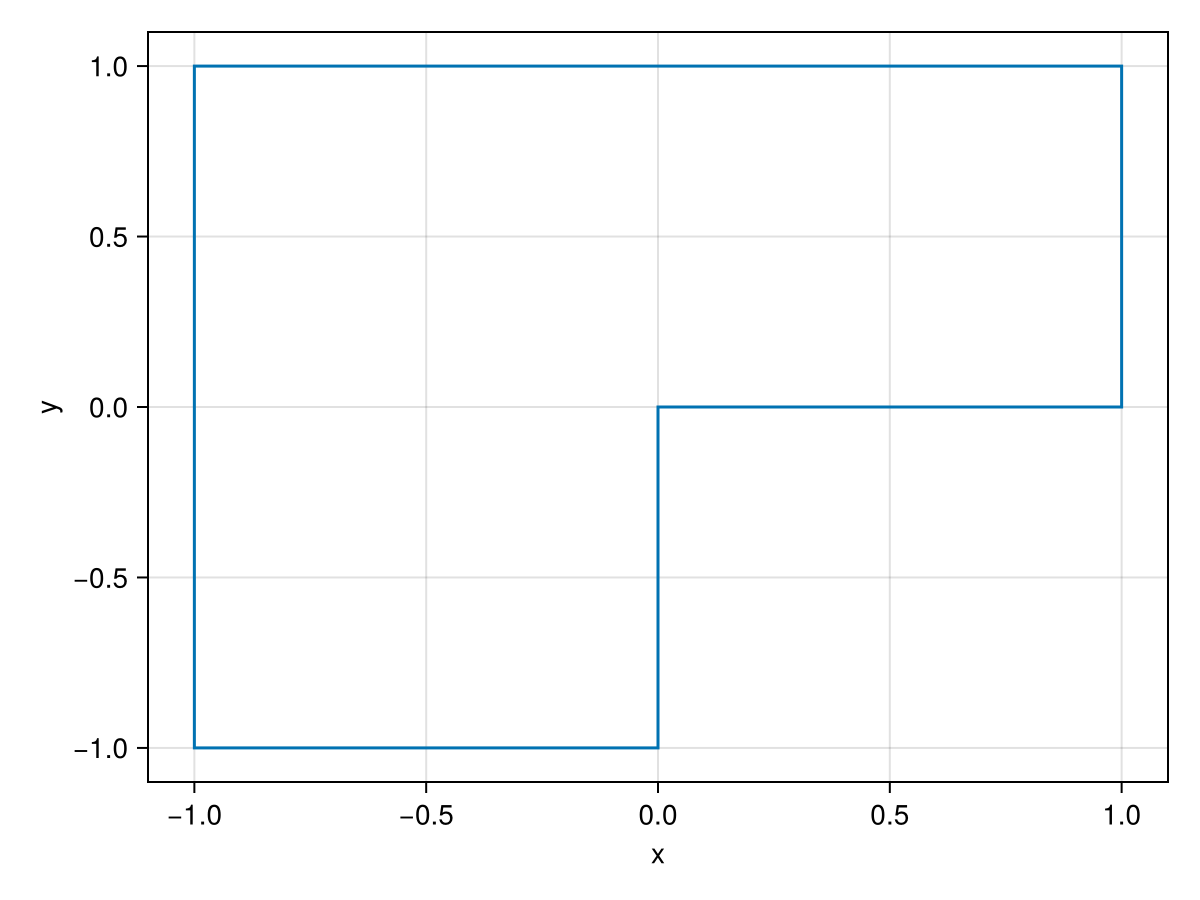

In [2]:
fig = Plt.Figure()
ax = Plt.Axis(fig[1, 1]; xlabel = "x", ylabel = "y")
points = [(0, 0), (1, 0), (1, 1), (-1, 1), (-1, -1), (0, -1), (0, 0)]
Plt.lines!(ax, first.(points), last.(points))
fig #hide

## Theoretical background
We have the following partial integration rules, where $\boldsymbol{n}$ is the outward pointing normal vector,
 following Monk (2003) [Monk2003; Eqs. (3.47) and (3.51)](@cite),
$$
\begin{align*}
\int_\Gamma \left[\boldsymbol{n}\times\boldsymbol{u}\right]\cdot\boldsymbol{\phi}\ \mathrm{d}\Gamma &=
\int_\Omega \left[\nabla \times \boldsymbol{u}\right]\cdot \boldsymbol{\phi}\ \mathrm{d}\Omega -
\int_\Omega \boldsymbol{u}\cdot\left[ \nabla \times \boldsymbol{\phi} \right]\ \mathrm{d}\Omega, \quad \boldsymbol{u} \in H(\mathrm{curl}),\ \boldsymbol{\phi} \in (\mathcal{C}^1)^3\\
\int_\Gamma \left[\boldsymbol{n}\times\boldsymbol{u}\right]\cdot\left[\left[\boldsymbol{n}\times\boldsymbol{\phi}\right]\times\boldsymbol{n}\right] \mathrm{d}\Gamma &=
\int_\Omega \left[\nabla \times \boldsymbol{u}\right]\cdot \boldsymbol{\phi}\ \mathrm{d}\Omega -
\int_\Omega \boldsymbol{u}\cdot\left[ \nabla \times \boldsymbol{\phi} \right]\ \mathrm{d}\Omega, \quad \boldsymbol{u},\ \boldsymbol{\phi}\in H(\mathrm{curl}),
\end{align*}
$$
respectively. Note that [Monk2003; Eq. (3.27)](@cite), requiring that $\boldsymbol{u} \in (\mathcal{C}^1)^3$,
is a special case of [Monk2003; Eq. (3.47)](@cite) as $(\mathcal{C}^1)^3 \subset H(\mathrm{curl})$.

We remark that in 2D for $\boldsymbol{u}$ pointing out of the plane, $\boldsymbol{u} = u_3 \boldsymbol{e}_3$,
and $\boldsymbol{\phi}$ in the plane, $\boldsymbol{\phi} \cdot \boldsymbol{e}_3 = 0$, we have
$$
\left[\boldsymbol{n}\times\boldsymbol{u}\right]\cdot\left[\left[\boldsymbol{n}\times\boldsymbol{\phi}\right]\times\boldsymbol{n}\right] = -u_3 \boldsymbol{\phi} \cdot \boldsymbol{t}
$$
where $\boldsymbol{t} = [-n_2,\ n_1]$ is the counter-clockwise tangent vector.
## Exact solution
In this example, we choose an exact solution, $\boldsymbol{E}_\mathrm{exact}(\boldsymbol{x})$,
that fullfills the differential equations. We then use $\boldsymbol{E}_\mathrm{exact}$ to
find $g$ to insert into the Dirichlet boundary conditions. Specifically, we choose
$$
\boldsymbol{E}_\mathrm{exact}(\boldsymbol{x}) = \mathrm{grad}(r^{2/3}\sin(2\theta/3))
$$
where $r$ and $\theta$ are the polar coordinates. Where $\theta$ is defined as the positive
angle measured from the $x$-axis.

The first PDE is directly satisfied by using the gradient to define the vector-valued solution,
since $\mathrm{curl}(\mathrm{grad}(u)) = 0$ holds for any field $u$. Furthermore,
along the lines, $\theta = 0$ and $\theta = 3\pi/2$, $\sin(2\theta/3) = 0$, such that the
$\boldsymbol{E}_\mathrm{exact} \cdot \boldsymbol{t} = 0$. Consequently, even if we have a
singularity at $\boldsymbol{x} = \boldsymbol{0}$, this doesn't enter the boundary conditions.
Finally, due to the singularity, the components of $\boldsymbol{E}_\mathrm{exact}$ are not in
$H^1(\Omega)$.
**TODO:** *Explain why $\mathrm{div}(\boldsymbol{E})=0$ is fullfilled, use divergence theorem?*

To evaluate the accuracy of the different discretizations, we will use the analytical solution to
evaluate the boundary condition,
$g = \boldsymbol{E}_\mathrm{exact}\cdot \boldsymbol{t} \quad \text{on }\Gamma$. A correct
discretization should then reproduce
$\boldsymbol{E}_\mathrm{exact}(\boldsymbol{x})\text{ in }\Omega$,
as $\boldsymbol{E}_\mathrm{exact}$ fulfills the PDE exactly, as well as its boundary conditions.

## Lagrange interpolation
Following the notes in the linked example, the lagrange problem becomes to solve
$$
\begin{align*}
\int_\Omega \mathrm{curl}(\delta \boldsymbol{E}) \cdot \mathrm{curl}(\boldsymbol{E})\ \mathrm{d}\Omega
+ \int_\Omega \mathrm{div}(\delta \boldsymbol{E}) \mathrm{div}(\boldsymbol{E})\ \mathrm{d}\Omega &= 0 \quad \forall\ \delta\boldsymbol{E} \in H^1 \\
\boldsymbol{E}\cdot\boldsymbol{t} &= g\quad \text{on }\Gamma
\end{align*}
$$

## Nedelec interpolation
Using a Lagrange multiplier, $\phi$, to weakly enforce the divergence equation,
we obtain the following problem:
Find $\boldsymbol{E}\in H(\mathrm{div})$ and $\phi\in H_0^1$, such that
$$
\begin{align*}
\int_\Gamma \left[\left[\boldsymbol{n}\times\delta\boldsymbol{E}\right]\times\boldsymbol{n}\right]\cdot
\left[\boldsymbol{n}\cdot\mathrm{curl}(\boldsymbol{E})\right]\ \mathrm{d}\Gamma +
\int_\Omega \mathrm{curl}(\delta\boldsymbol{E})\cdot\mathrm{curl}(\boldsymbol{E})\ \mathrm{d}\Omega +
\int_\Omega \delta\boldsymbol{E}\cdot\mathrm{grad}(\phi)\ \mathrm{d}\Omega &= 0\\
\int_\Omega \mathrm{grad}(\delta\phi) \cdot \boldsymbol{E}\ \mathrm{d}\Omega &= 0 \\
\boldsymbol{E}\cdot \boldsymbol{t} &= g\; \text{on }\Gamma
\end{align*}
$$
for all $\delta\boldsymbol{E}\in H_0(\mathrm{curl})$ and $\delta\phi\in H_0^1$.

We then use `FerriteGmsh.jl` to create the grid

In [3]:
function setup_grid(h = 0.2; origin_refinement = 1)
    # Initialize gmsh
    Gmsh.initialize()
    gmsh.option.set_number("General.Verbosity", 2)

    # Add the points, finer grid at the discontinuity
    o = gmsh.model.geo.add_point(0.0, 0.0, 0.0, h / origin_refinement)
    p1 = gmsh.model.geo.add_point(1.0, 0.0, 0.0, h)
    p2 = gmsh.model.geo.add_point(1.0, 1.0, 0.0, h)
    p3 = gmsh.model.geo.add_point(-1.0, 1.0, 0.0, h)
    p4 = gmsh.model.geo.add_point(-1.0, -1.0, 0.0, h)
    p5 = gmsh.model.geo.add_point(0.0, -1.0, 0.0, h)

    pts = [o, p1, p2, p3, p4, p5, o]
    # Add the lines
    lines = [gmsh.model.geo.add_line(pts[i - 1], pts[i]) for i in 2:length(pts)]

    # Create the closed curve loop and the surface
    loop = gmsh.model.geo.add_curve_loop(lines)
    gmsh.model.geo.add_plane_surface([loop])

    # Synchronize the model
    gmsh.model.geo.synchronize()

    # Generate a 2D mesh
    gmsh.model.mesh.generate(2)

    # Save the mesh, and read back in as a Ferrite Grid
    grid = mktempdir() do dir
        path = joinpath(dir, "mesh.msh")
        gmsh.write(path)
        togrid(path)
    end

    # Finalize the Gmsh library
    Gmsh.finalize()

    # Add boundary parts
    top = ExclusiveTopology(grid)
    addboundaryfacetset!(grid, top, "vertical_facets", x -> abs((x[1] - 1) * x[1] * (x[1] + 1)) ≤ 1.0e-6)
    addboundaryfacetset!(grid, top, "horizontal_facets", x -> abs((x[2] - 1) * x[2] * (x[2] + 1)) ≤ 1.0e-6)
    bfacets = union(getfacetset(grid, "vertical_facets"), getfacetset(grid, "horizontal_facets"))
    addfacetset!(grid, "boundary_facets", bfacets)
    return grid
end

setup_grid (generic function with 2 methods)

And prepare some functions to process and plot the data on the grid
by using `FerriteTriangulation.jl`

In [4]:
function _create_data!(f, data, a, cvs, subtria::SubTriangulation, dr::UnitRange)
    sdh = subtria.sdh
    grid = sdh.dh.grid
    c1 = first(subtria.faces)[1]
    x = copy(getcoordinates(grid, c1))
    dofs = copy(celldofs(sdh, c1))
    ae = zeros(eltype(a), length(dofs))
    for (i, (cellnr, facenr)) in enumerate(subtria.faces)
        cv = cvs[facenr]
        getcoordinates!(x, grid, cellnr)
        reinit!(cv, getcells(grid, cellnr), x)
        celldofs!(dofs, sdh, cellnr)
        copyto!(ae, view(a, dofs))
        node_idxs = subtria.face_nodes[i]:(subtria.face_nodes[i + 1] - 1)
        for q_point in 1:getnquadpoints(cv)
            data[node_idxs[q_point]] = f(function_value(cv, q_point, ae, dr))
        end
    end
    return
end

"""
    create_data(tr::Triangulation, grid::AbstractGrid, a::Vector{<:Number}, ::NTuple{N, <:Interpolation};
        f = identity)

Create scalar data by evaluating `f(function_value(...))` at each triangulation node in the `grid`.
"""
function create_data(tr::Triangulation, fieldname::Symbol, a; f = identity)
    data = zeros(length(tr.nodes))
    dh = first(tr.sub_triangulation).sdh.dh
    if length(a) != ndofs(dh)
        display(dh)
        println((dh = ndofs(dh), a = length(a)))
        error("dof vector length not matching number of dofs in triangulation dh")
    end

    for subtria in tr.sub_triangulation
        sdh = subtria.sdh
        ip = Ferrite.getfieldinterpolation(sdh, fieldname)
        cvs = [CellValues(cr, ip, geometric_interpolation(getcelltype(subtria.sdh))) for cr in subtria.rules]
        _create_data!(f, data, a, cvs, subtria, dof_range(sdh, fieldname))
    end
    return data
end

Main.var"##321".create_data

## Analytical implementation

In [5]:
mesh_size = 0.01
grid = setup_grid(mesh_size; origin_refinement = 1)

dh_ana = close!(add!(DofHandler(grid), :u, DiscontinuousLagrange{RefTriangle, 1}()^2))

function analytical_potential(x::Vec{2}) # Analytical potential to be differentiated
    Δθ = -3π / 4 # Rotate discontinuous line to 4th quadrant
    xp = rotate(x, Δθ)
    r = sqrt(x ⋅ x + eps())
    θ = r ≤ 1.0e-6 ? zero(eltype(x)) : (atan(xp[2], xp[1]) - Δθ)
    return r^(2 // 3) * sin(2θ / 3)
end
analytical_solution(x::Vec{2}) = gradient(analytical_potential, x)

a_ana = zeros(ndofs(dh_ana))

apply_analytical!(a_ana, dh_ana, :u, analytical_solution);

## Error calculation
We will calculate the error, $e(h)$, between the analytical,
$\boldsymbol{E}_\mathrm{exact}$, and numerical,
$\boldsymbol{E}_\mathrm{h}(h)$, solutions as integral norm,
$$
e(h) = \frac{1}{V}\int_\Omega ||\boldsymbol{E}_\mathrm{h}(h) - \boldsymbol{E}_\mathrm{exact}||^2\ \mathrm{d}\Omega,
\quad V = \int_\Omega \mathrm{d}\Omega
$$
where $h$ is a measure of the element size.

In [6]:
mutable struct L2Error{F}
    l2error::Float64
    volume::Float64
    const exact_fun::F
end

function FerriteAssembly.integrate_cell!(vals::L2Error{F}, state, ae, material, cv::CellValues, cellbuffer) where {F}
    for q_point in 1:getnquadpoints(cv)
        Eh = function_value(cv, q_point, ae)
        x = spatial_coordinate(cv, q_point, getcoordinates(cellbuffer))
        dΩ = getdetJdV(cv, q_point)
        vals.l2error += norm(Eh - vals.exact_fun(x))^2 * dΩ
        vals.volume += dΩ
    end
    return
end
function FerriteAssembly.integrate_cell!(vals::L2Error{F}, state, ae, material, cv::NamedTuple, cellbuffer) where {F}
    for q_point in 1:getnquadpoints(cv.E)
        Eh = function_value(cv.E, q_point, ae, dof_range(cellbuffer, :E))
        x = spatial_coordinate(cv.E, q_point, getcoordinates(cellbuffer))
        dΩ = getdetJdV(cv.E, q_point)
        vals.l2error += norm(Eh - vals.exact_fun(x))^2 * dΩ
        vals.volume += dΩ
    end
    return
end;

## Lagrange solution

In [7]:
struct LagrangeMaterial end
function FerriteAssembly.element_routine!(Ke, re, s, ae, ::LagrangeMaterial, cv, cellbuffer)
    for q_point in 1:getnquadpoints(cv)
        dΩ = getdetJdV(cv, q_point)
        for i in 1:getnbasefunctions(cv)
            div_δNi = shape_divergence(cv, q_point, i)
            curl_δNi = shape_curl(cv, q_point, i)
            for j in 1:getnbasefunctions(cv)
                div_Nj = shape_divergence(cv, q_point, j)
                curl_Nj = shape_curl(cv, q_point, j)
                Ke[i, j] += (curl_δNi ⋅ curl_Nj + div_δNi * div_Nj) * dΩ
            end
        end
    end
    return
end

function solve_lagrange(dh)
    ip = Ferrite.getfieldinterpolation(dh, Ferrite.find_field(dh, :E))
    ch = ConstraintHandler(dh)
    add!(ch, Dirichlet(:E, getfacetset(dh.grid, "horizontal_facets"), (x, _) -> gradient(analytical_potential, x)[2], [2]))
    add!(ch, Dirichlet(:E, getfacetset(dh.grid, "vertical_facets"), (x, _) -> gradient(analytical_potential, x)[1], [1]))
    close!(ch)

    cv = CellValues(QuadratureRule{RefTriangle}(1), ip)
    K = allocate_matrix(dh)
    f = zeros(ndofs(dh))
    db = setup_domainbuffer(DomainSpec(dh, LagrangeMaterial(), cv))
    as = start_assemble(K, f)
    work!(as, db)
    apply!(K, f, ch)
    a = K \ f
    l2_vals = L2Error(0.0, 0.0, analytical_solution)
    work!(Integrator(l2_vals), db; a)
    return a, sqrt(l2_vals.l2error) / l2_vals.volume
end

dh_lagrange = close!(add!(DofHandler(grid), :E, Lagrange{RefTriangle, 1}()^2))
a_lagrange, e_lagrange = solve_lagrange(dh_lagrange)

function lagrange_error(grid)
    ip = Lagrange{RefTriangle, 1}()^2
    dh = close!(add!(DofHandler(grid), :E, ip))
    _, e = solve_lagrange(dh)
    return e
end;

## Nedelec solution

In [8]:
struct NedelecMaterial end
function FerriteAssembly.element_residual!(re, s, ae, ::NedelecMaterial, cv, cellbuffer)
    for q_point in 1:getnquadpoints(cv.E)
        dΩ = getdetJdV(cv.E, q_point)
        E = function_value(cv.E, q_point, ae, dof_range(cellbuffer, :E))
        curlE = function_curl(cv.E, q_point, ae, dof_range(cellbuffer, :E))
        ∇ϕ = function_gradient(cv.ϕ, q_point, ae, dof_range(cellbuffer, :ϕ))
        for (i, I) in pairs(dof_range(cellbuffer, :E))
            δNE = shape_value(cv.E, q_point, i)
            curl_δNE = shape_curl(cv.E, q_point, i)
            re[I] += (curl_δNE ⋅ curlE + δNE ⋅ ∇ϕ) * dΩ
        end
        for (i, I) in pairs(dof_range(cellbuffer, :ϕ))
            gradδNϕ = shape_gradient(cv.ϕ, q_point, i)
            re[I] += (gradδNϕ ⋅ E) * dΩ
        end
    end
    return
end

function solve_nedelec(dh)
    ipE = Ferrite.getfieldinterpolation(dh, Ferrite.find_field(dh, :E))
    ipϕ = Ferrite.getfieldinterpolation(dh, Ferrite.find_field(dh, :ϕ))
    CT = getcelltype(dh.grid)

    ch = ConstraintHandler(dh)
    add!(ch, WeakDirichlet(:E, getfacetset(dh.grid, "boundary_facets"), (x, _, n) -> analytical_solution(x) × n))
    add!(ch, Dirichlet(:ϕ, getfacetset(dh.grid, "boundary_facets"), Returns(0.0)))
    close!(ch)

    qr = QuadratureRule{RefTriangle}(1)
    ipg = geometric_interpolation(CT)
    cv = (E = CellValues(qr, ipE, ipg), ϕ = CellValues(qr, ipϕ, ipg))
    K = allocate_matrix(dh)
    f = zeros(ndofs(dh))
    db = setup_domainbuffer(DomainSpec(dh, NedelecMaterial(), cv); autodiffbuffer = true)
    as = start_assemble(K, f)
    a = zeros(ndofs(dh))
    work!(as, db; a)
    apply!(K, f, ch)
    a .= K \ f
    l2_vals = L2Error(0.0, 0.0, analytical_solution)
    work!(Integrator(l2_vals), db; a)
    return a, sqrt(l2_vals.l2error) / l2_vals.volume
end

ipE = Nedelec{2, RefTriangle, 1}()
ipϕ = Lagrange{RefTriangle, 1}()
dh_nedelec = DofHandler(grid)
add!(dh_nedelec, :E, ipE)
add!(dh_nedelec, :ϕ, ipϕ)
close!(dh_nedelec)

a_nedelec, e_nedelec = solve_nedelec(dh_nedelec)

function nedelec_error(grid)
    ipE = Nedelec{2, RefTriangle, 1}()
    ipϕ = Lagrange{RefTriangle, 1}()
    dh = DofHandler(grid)
    add!(dh, :E, ipE)
    add!(dh, :ϕ, ipϕ)
    close!(dh)
    _, e = solve_nedelec(dh)
    return e
end

function calculate_errors(mesh_sizes)
    lagrange_errors = zeros(length(mesh_sizes))
    nedelec_errors = similar(lagrange_errors)
    for (i, h) in enumerate(mesh_sizes)
        grid = setup_grid(h; origin_refinement = 1)
        lagrange_errors[i] = lagrange_error(grid)
        nedelec_errors[i] = nedelec_error(grid)
    end
    return lagrange_errors, nedelec_errors
end

mesh_sizes = 0.1 * ((1 / 2) .^ (0:5));
lagrange_errors = [0.10849541129807588, 0.09262531863237256, 0.08372918040381809, 0.07939314534131932, 0.07639600032795617, 0.07579072269391056]; #hide
nedelec_errors = [0.02246208564658041, 0.014303181582571767, 0.00906062850047998, 0.0057408487615066535, 0.003616459776120822, 0.0022876386764458592]; #hide

```julia
lagrange_errors, nedelec_errors = calculate_errors(mesh_sizes)
```

In [9]:
function plot_field(fig_part, dh, fieldname, dofvec, name::String; plot_edges = false, meshkwargs...)
    tr = Triangulation(dh, 2)
    data = create_data(tr, fieldname, dofvec; f = (x -> x[1]))

    ax = Plt.Axis(fig_part; aspect = Plt.DataAspect(), xlabel = "x₁", ylabel = "x₂", title = name)

    nodes = [GB.Point(x.data) for x in tr.nodes]
    m = Plt.mesh!(
        ax, nodes, reshape(tr.triangles, :); color = data,
        colormap = Plt.Makie.wong_colors(),
        interpolate = true,
        meshkwargs...
    )
    if plot_edges
        for i in 2:length(tr.tri_edges)
            Plt.lines!(ax, view(nodes, view(tr.edges, tr.tri_edges[i - 1]:(tr.tri_edges[i] - 1))); color = :black)
        end
    end
    return m
end

fig = let
    fig = Plt.Figure(size = (1000, 600))
    m_ana = plot_field(fig[1, 1], dh_ana, :u, a_ana, "Analytical"; plot_edges = false, colorrange = (-2, 0))
    m_lag = plot_field(fig[1, 2], dh_lagrange, :E, a_lagrange, "Lagrange (h = $mesh_size)"; plot_edges = false, colorrange = (-2, 0))
    m_ned = plot_field(fig[1, 3], dh_nedelec, :E, a_nedelec, "Nedelec (h = $mesh_size)"; plot_edges = false, colorrange = (-2, 0))
    Plt.Colorbar(fig[1, 4], m_ned; label = "E₁")

    ax = Plt.Axis(
        fig[2, 1:2];
        xscale = log10, yscale = log10,
        xlabel = "mesh size, h", ylabel = "error"
    )
    Plt.lines!(ax, mesh_sizes, lagrange_errors; label = "Lagrange")
    Plt.lines!(ax, mesh_sizes, nedelec_errors; label = "Nedelec")
    Plt.axislegend(ax; position = :rb)

    fig
end;

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*